In [1]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.datasets import cifar10

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, cuda

In [3]:
# data = np.load("/kaggle/input/cifar10-keras-files-cifar10load-data/cifar-10.npz")

# filenames = ["x_train","y_train","x_test","y_test"]

# nps = []

# for filename in filenames:
#     nps.append(data[filename])

# x_train, y_train, x_label, y_label = nps
(x_train, y_train), (x_label, y_label) = cifar10.load_data()

In [4]:
x_train.shape

(50000, 32, 32, 3)

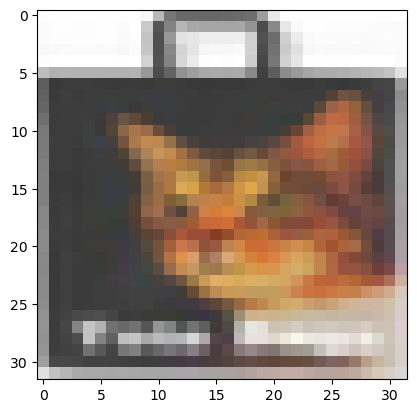

In [5]:
plt.imshow(x_train[3000])

## Limpieza de datos

In [6]:
x_train = x_train.astype('float32')/255
x_label = x_label.astype('float32')/255

In [7]:
num_class = len(np.unique(y_train)) # Se tiene valores unicos
y_train = to_categorical(y_train, num_class)
y_label = to_categorical(y_label, num_class)
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [8]:
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

print('x_train shape', x_train.shape)
print('train', x_train.shape[0])
print('val', x_valid.shape[0])
print('test', x_label.shape[0])

x_train shape (45000, 32, 32, 3)
train 45000
val 5000
test 10000


# Creacion del modelo

In [9]:
base_filters=32
w_regulatizer = 1e-4
x_train.shape[1:]

(32, 32, 3)

In [15]:
# @jit(target_backend='cuda')
def model():
    model = Sequential()
    # Cpnvolucion 1
    model.add(Conv2D(base_filters, (3,3), padding="same", kernel_regularizer= regularizers.l2(w_regulatizer), input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    # Cpnvolucion 2
    model.add(Conv2D(base_filters, (3,3), padding="same", kernel_regularizer= regularizers.l2(w_regulatizer)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    # Cpnvolucion 3
    model.add(Conv2D(2*base_filters, (3,3), padding="same", kernel_regularizer= regularizers.l2(w_regulatizer)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    # Cpnvolucion 4
    model.add(Conv2D(2*base_filters, (3,3), padding="same", kernel_regularizer= regularizers.l2(w_regulatizer)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    # Cpnvolucion 5
    model.add(Conv2D(4*base_filters, (3,3), padding="same", kernel_regularizer= regularizers.l2(w_regulatizer)))
    model.add(Activation('relu'))
    # Cpnvolucion 6
    model.add(Conv2D(4*base_filters, (3,3), padding="same", kernel_regularizer= regularizers.l2(w_regulatizer)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    # Clasificacion - Flatten
    model.add(Flatten())
    model.add(Dense(num_class, activation="softmax"))


    model.summary()
    return model
model = model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_18 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_19 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 16, 16, 32)        0         
                                                      

In [16]:
# @jit(target_backend='cuda')
def compiler(model):
    model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])
    hist = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_valid, y_valid), verbose=2, shuffle=True)
    return hist

hist = compiler(model)

Epoch 1/100
1407/1407 - 525s - loss: 1.7067 - accuracy: 0.3875 - val_loss: 1.3961 - val_accuracy: 0.5158 - 525s/epoch - 373ms/step
Epoch 2/100


In [ ]:
plt.plot(hist.history["accuracy"], label="Train")
plt.plot(hist.history["val_accuracy"], label="val")
plt.legend()
plt.show()

In [ ]:
model.evaluate(x_label, y_label)